# 1. Describe the data
- It has 124 observations.
- There are 3 variables:
    - thorax: The thorax length of each male fruitfly, measured in millimeters.
    - longevity: The lifespan of each fruitfly, measured in days.
    - activity: The group to which each fruitfly belongs, indicating their mating conditions:
        - isolated: Kept solitary.
        - one: Kept with one pregnant female daily.
        - many: Kept with eight pregnant females daily.
        - low: Kept with one virgin female daily.
        - high: Kept with eight virgin females daily.
- We studied the sexual activity and lifespan of male fruitflies (Partridge & Farquhar, 1981). 125 fruitflies were divided into five groups of 25: with one virgin female daily, with eight virgin females daily, with one pregnant female daily, and with eight pregnant females daily. Pregnant fruitflies will not mate. We measured the thorax length of each male because it affects how long they live. The thorax is the middle part of an insect’s body, located between the head and the abdomen. The five groups are labeled isolated, low, high, one and many. The goal was to determine differences in lifespan among the groups.

# 2. Load packages and data

In [1]:
%%capture
pip install faraway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import faraway.utils
import patsy

In [10]:
import faraway.datasets.fruitfly
ff = faraway.datasets.fruitfly.load()
ff.head()

,thorax,longevity,activity
1,0.68,37,many
2,0.68,49,many
3,0.72,46,many
4,0.72,63,many
5,0.76,39,many


# 3. Linear Regression with Factor

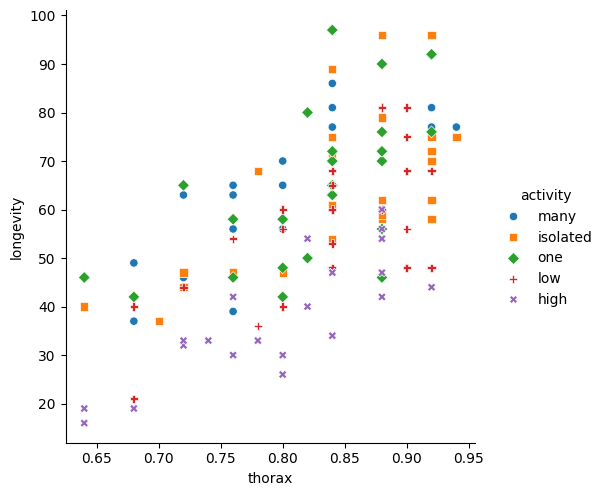

In [6]:
sns.pairplot(x_vars="thorax", y_vars="longevity", data=ff, 
    hue="activity", height=5, markers=["o", "s", "D", "P", "X"]);

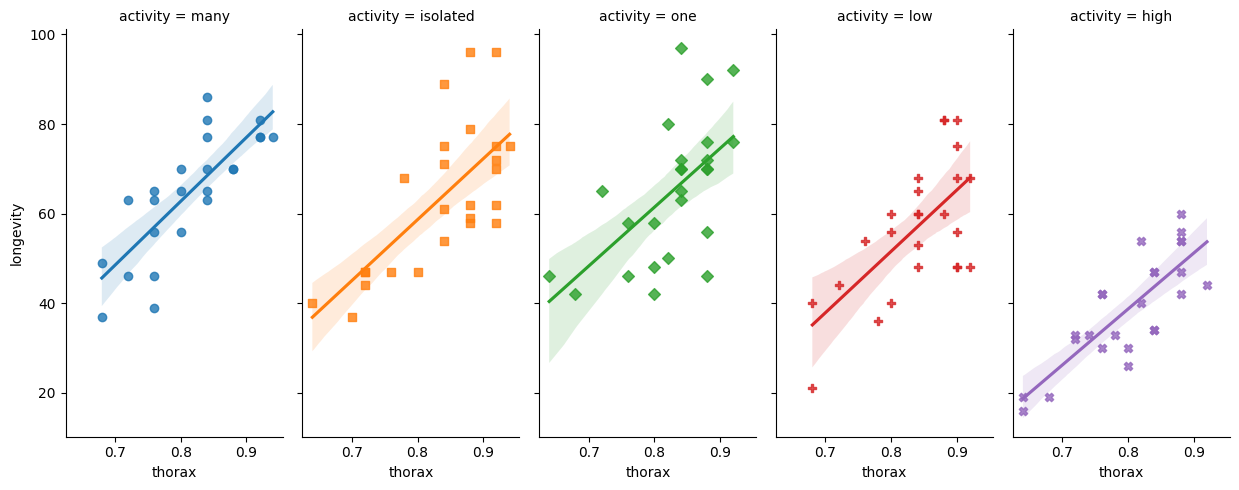

In [18]:
sns.lmplot(x="thorax", y="longevity", data=ff, hue="activity", col="activity", 
           height=5, aspect=0.5, markers=["o", "s", "D", "P", "X"])
# height=5 sets the height of each subplot. e.g., 4, 6, 8.

# aspect=1 sets the aspect ratio of each subplot. e.g., 0.5, 1.5, 2.

# markers=["o", "s", "D", "P", "X"] specifies different markers for each group.
# Popular options: ["o", "s", "D"], ["^", "v", "<", ">"], ["*", "x", "+"].

# ci=None removes the confidence interval around the regression line.
# Popular options: None (no confidence interval), 95 (95% confidence interval), 99 (99% confidence interval).

# Adjust layout
plt.tight_layout()

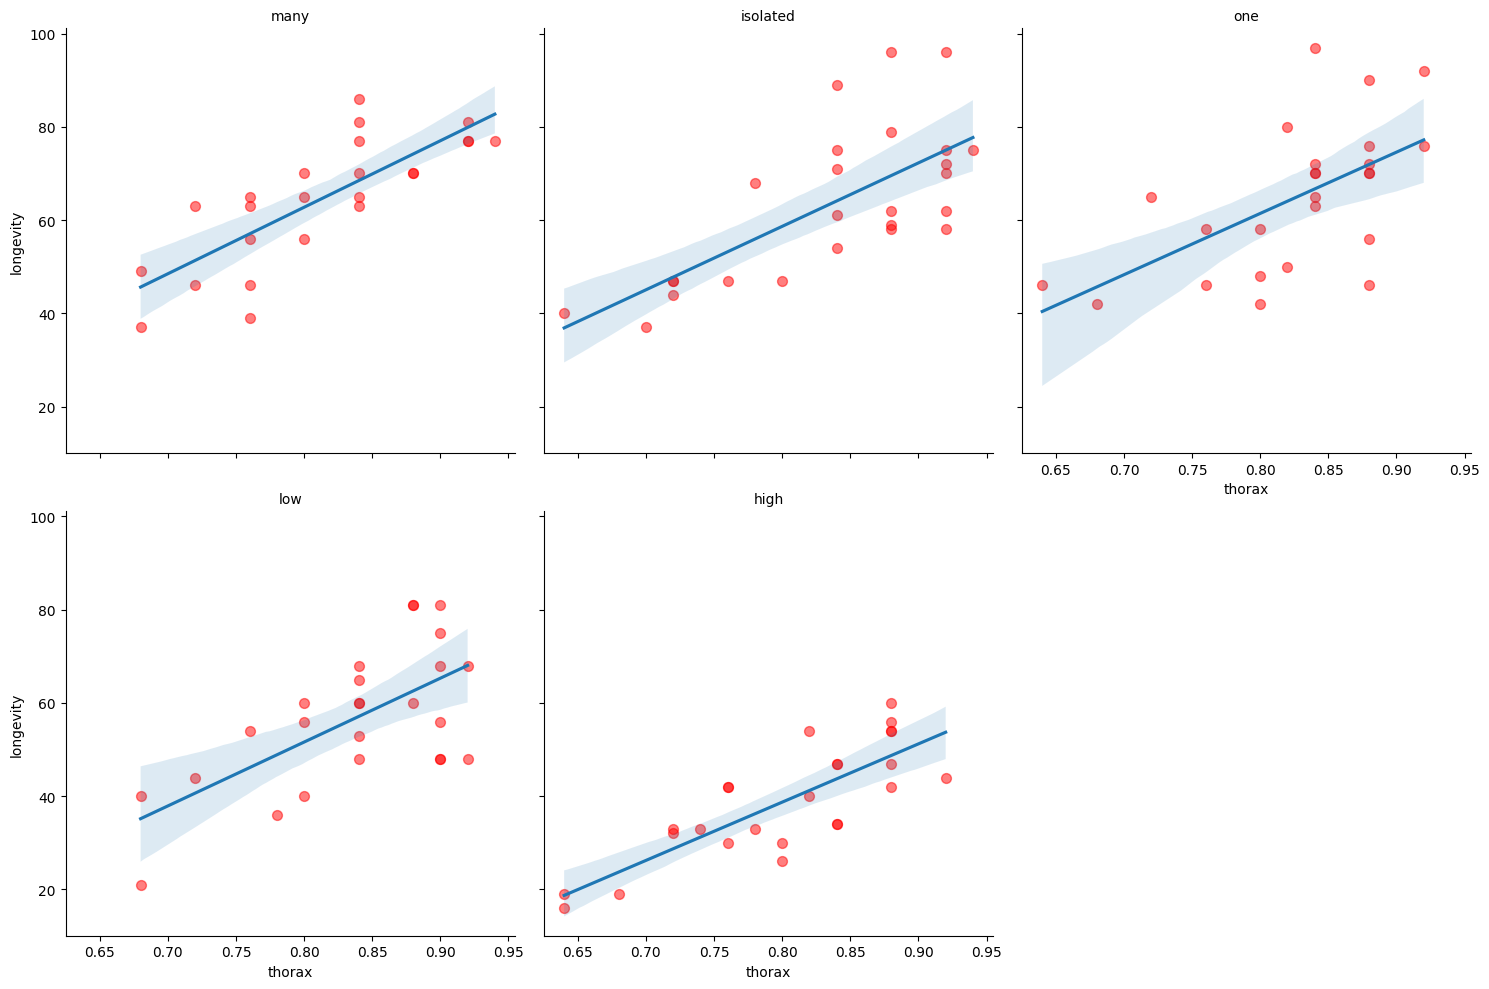

In [28]:
# Create a FacetGrid with 3 columns and 2 rows
g = sns.FacetGrid(ff, col="activity", col_wrap=3, height=5, aspect=1)

# Map the scatter plot with regression line to the grid
g.map(sns.regplot, "thorax", "longevity", ci=95, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'red'})
# scatter_kws={'s': 50, 'alpha': 0.5} customizes the scatter plot markers.
# Popular options:
# 's': size of the markers, e.g., 20, 50, 100.
# 'alpha': transparency of the markers, e.g., 0.3, 0.5, 0.8.
# 'color': color of the markers, e.g., 'blue', 'red', 'green'.
# 'edgecolor': color of the marker edges, e.g., 'black', 'white'.
# 'linewidth': width of the marker edges, e.g., 0.5, 1, 1.5.


# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
plt.tight_layout()

- The plot makes it clearer that longevity for the high sexual activity group is lower.

In [11]:
# Set 'isolated' as the reference category for 'activity'
ff['activity'] = pd.Categorical(ff['activity'], 
                    categories=['isolated', 'one', 'many', 'low', 'high']) 
# Fit the model
lmod = smf.ols('longevity ~ thorax*activity', data=ff).fit()
lmod.sumary()

                          coefs stderr tvalues pvalues
Intercept               -50.242 21.801   -2.30  0.0230
activity[T.one]           6.517 33.871    0.19  0.8478
activity[T.many]         -1.139 32.530   -0.04  0.9721
activity[T.low]          -7.750 33.969   -0.23  0.8199
activity[T.high]        -11.038 31.287   -0.35  0.7249
thorax                  136.127 25.952    5.25  0.0000
thorax:activity[T.one]   -4.677 40.652   -0.12  0.9086
thorax:activity[T.many]   6.548 39.360    0.17  0.8682
thorax:activity[T.low]    0.874 40.425    0.02  0.9828
thorax:activity[T.high] -11.127 38.120   -0.29  0.7709

n=124 p=10 Residual SD=10.713 R-squared=0.65


- Since "isolated" is the reference level, the fitted regression line within this group is longevity= -50.2 + 136.1*thorax.
- For "many," it is longevity= ( -50.2 - 1.1) + (136.1 +6.5)*thorax.
- Similar calculations can be made for the other groups.
- We look at the design matrix to see how the variables are coded. We look at only (one) the low level so the matrix is not too big.

In [13]:
# Design matrix for the group low
mm = patsy.dmatrix('~ thorax*activity', ff)
ii = (1, 25, 49, 75, 99)
p = pd.DataFrame(mm[ii,:], index=ii, columns=lmod.params.index)
p.iloc[:,[0,1,5,6]]

,Intercept,activity[T.one],thorax,thorax:activity[T.one]
1,1.0,0.0,0.68,0.00
25,1.0,0.0,0.70,0.00
49,1.0,1.0,0.64,0.64
75,1.0,0.0,0.68,0.00
99,1.0,0.0,0.64,0.00


- There might be some heteroscedasticity, but we’ll ignore it for now to keep things simple. 
- We’ll check if we can simplify the model. The model summary isn’t helpful here because it shows four separate tests for the interaction term, but we need just one overall test. We can get this by using:

In [14]:
sm.stats.anova_lm(lmod, typ = 1)
# Perform ANOVA
# Type I ANOVA (sequential sums of squares)
# - Tests each term sequentially in the order they appear in the model.
# - The first term is tested without any other terms.
# - Each subsequent term is tested after accounting for the previous terms.
# Type II ANOVA (sums of squares adjusted for other variables)
# - Tests each term after accounting for all other terms, except interactions.
# - Useful when you want to test the main effects without considering interactions.
# Type III ANOVA (sums of squares adjusted for all other variables)
# - Tests each term after accounting for all other terms, including interactions.
# - Useful when you want to test each term in the presence of all other terms.

,df,sum_sq,mean_sq,F,PR(>F)
activity,4.0,12269.467151,3067.366788,26.727833,1.200318e-15
thorax,1.0,12368.420833,12368.420833,107.773577,3.565139e-18
thorax:activity,4.0,24.313592,6.078398,0.052965,9.946914e-01
Residual,114.0,13082.983907,114.763017,NaN,NaN


In [15]:
lmod2 = smf.ols('longevity ~ thorax + activity + thorax:activity', data=ff).fit()
sm.stats.anova_lm(lmod2, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
activity,4.0,12269.467151,3067.366788,26.727833,1.200318e-15
thorax,1.0,12368.420833,12368.420833,107.773577,3.565139e-18
thorax:activity,4.0,24.313592,6.078398,0.052965,9.946914e-01
Residual,114.0,13082.983907,114.763017,NaN,NaN


In [16]:
# Fit the models in the desired order: thorax + activity + thorax:activity
model0 = smf.ols('longevity ~ 1', data=ff).fit()
model1 = smf.ols('longevity ~ thorax', data=ff).fit()
model2 = smf.ols('longevity ~ thorax + activity', data=ff).fit()
model3 = smf.ols('longevity ~ thorax * activity', data=ff).fit()

# Perform ANOVA sequentially
sm.stats.anova_lm(model0, model1, model2, model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,123.0,37745.185484,0.0,NaN,NaN,NaN
1,122.0,22741.885030,1.0,15003.300454,130.732887,5.051042e-21
2,118.0,13107.297500,4.0,9634.587530,20.988006,4.348953e-13
3,114.0,13082.983907,4.0,24.313592,0.052965,9.946914e-01


- This is a sequential analysis of variance (ANOVA) table. It starts with a null model and adds terms one by one, testing each sequentially. The table lists the models for both the null and alternative hypotheses.
- <span style="color:red">Can we change order of test? Put thorax before activity</span>.
| Null | Alternative |
|----------|----------|
|y ~ 1|y ~ activity|
|y ~ activity|y ~ thorax + activity|
|y ~ thorax + activity|y ~ thorax + activity + thorax:activity|
- We aim to simplify the full model step by step and then interpret the results. The interaction term thorax:activity is not significant, suggesting that the slope can be the same for each group. No further simplification is possible.
- The F-statistic for the interaction term is very small, with a p-value close to one. This suggests that the regression lines for the five groups are nearly parallel, which could happen by chance. In some cases, unusually large p-values have raised suspicions of data tampering. For example, Ronald Fisher suspected Gregor Mendel of manipulating data in genetics experiments because the results seemed too perfect (Fisher, 1936).
- We refit without the interaction term:

In [17]:
lmod = smf.ols('longevity ~ thorax + activity', ff).fit()
lmod.sumary()

                   coefs stderr tvalues pvalues
Intercept        -48.749 10.850   -4.49  0.0000
activity[T.one]    2.637  2.984    0.88  0.3786
activity[T.many]   4.139  3.027    1.37  0.1741
activity[T.low]   -7.015  2.981   -2.35  0.0203
activity[T.high] -20.004  3.016   -6.63  0.0000
thorax           134.341 12.731   10.55  0.0000

n=124 p=6 Residual SD=10.539 R-squared=0.65


- “Isolated” is the reference group. The intercepts for “one” and “many” are not significantly different from this reference. The “low” sexual activity group lives about seven days less, with a p-value of 0.02, which is significant for a single comparison. However, since multiple comparisons are being made, a Bonferroni adjustment might be needed, which would negate this significance. The “high” sexual activity group lives 20 days less than the reference group, and this difference is strongly significant.

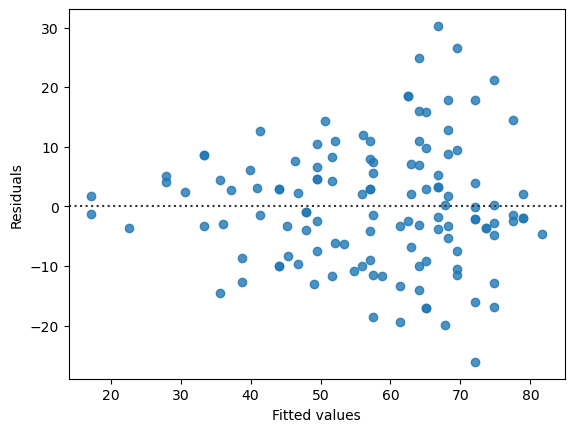

In [18]:
# Diagnostics
g = sns.residplot(x=lmod.fittedvalues, y=lmod.resid)
g.set(xlabel="Fitted values", ylabel="Residuals");

- We observe some nonconstant variance, which doesn’t seem linked to the five groups. Applying a log transformation can address this heteroscedasticity:

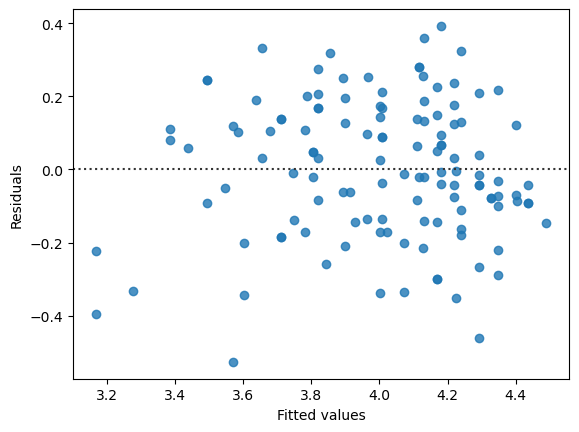

In [19]:
lmod = smf.ols('np.log(longevity) ~ thorax + activity', ff).fit()
g = sns.residplot(x=lmod.fittedvalues, y=lmod.resid)
g.set(xlabel="Fitted values", ylabel="Residuals");

- One disadvantage of transformation is that it can make interpretation of the model more difficult. Let's examine the model fit:

In [20]:
lmod.sumary()

                  coefs stderr tvalues pvalues
Intercept         1.844  0.199    9.28  0.0000
activity[T.one]   0.052  0.055    0.95  0.3459
activity[T.many]  0.088  0.055    1.59  0.1156
activity[T.low]  -0.124  0.055   -2.27  0.0252
activity[T.high] -0.419  0.055   -7.59  0.0000
thorax            2.721  0.233   11.67  0.0000

n=124 p=6 Residual SD=0.193 R-squared=0.70


- $R^2$ is higher for this model, but the p-values are similar.
- With the log transformation, the coefficients can be interpreted as having a multiplicative effect.

In [21]:
np.round(np.exp(lmod.params[1:5]), 2)

activity[T.one]     1.05
activity[T.many]    1.09
activity[T.low]     0.88
activity[T.high]    0.66
dtype: float64

- Compared to the reference level "isolated", we see that the high sexual activity group has 0.66 times the life span (i.e., 34% less).
- Why did we include thorax in the model? Its impact on longevity was already known. However, since the flies were randomly assigned to groups, including thorax won’t bias the estimates of the activity effects. We can confirm that thorax is unrelated to the activities:

In [22]:
lmod = smf.ols('thorax ~ activity', ff).fit()
sm.stats.anova_lm(lmod)

,df,sum_sq,mean_sq,F,PR(>F)
activity,4.0,0.025552,0.006388,1.109227,0.355481
Residual,119.0,0.685322,0.005759,NaN,NaN


- However, look what happens if we omit thorax from the model for longevity:

In [23]:
lmod = smf.ols('np.log(longevity) ~ activity', ff).fit()
lmod.sumary()

                  coefs stderr tvalues pvalues
Intercept         4.119  0.056   72.99  0.0000
activity[T.one]   0.023  0.080    0.29  0.7695
activity[T.many]  0.024  0.081    0.30  0.7670
activity[T.low]  -0.120  0.080   -1.50  0.1370
activity[T.high] -0.517  0.080   -6.48  0.0000

n=124 p=5 Residual SD=0.282 R-squared=0.36


- The magnitudes of the effects remain similar, but the standard errors increase significantly. Including thorax in the model enhances the precision of the estimates.

# 4. Alternative Codings of Factors
- Alternative codings of factor variables can be useful. For example, instead of the default treatment coding, we can use sum coding:

In [24]:
smod = smf.ols('np.log(longevity) ~ C(activity,Sum)', ff).fit()
smod.sumary()

                              coefs stderr tvalues pvalues
Intercept                     4.001  0.025  157.88  0.0000
C(activity, Sum)[S.isolated]  0.118  0.051    2.33  0.0214
C(activity, Sum)[S.one]       0.141  0.051    2.80  0.0060
C(activity, Sum)[S.many]      0.142  0.051    2.76  0.0066
C(activity, Sum)[S.low]      -0.002  0.051   -0.03  0.9741

n=124 p=5 Residual SD=0.282 R-squared=0.36


- The model fit remains the same, with identical residual standard error and R², but the parameter estimates differ. In treatment coding, the reference level “isolated” has an intercept of 4.119, and “low” is 3.999 (4.119 - 0.120). In sum coding, the intercept is the overall mean, 4.001, and “low” is 3.999 (4.001 - 0.002). Thus, the estimated effects are the same, but the parameterization differs.
- In sum coding, factor effects sum to zero, so the dummy variable for the last level is omitted to avoid identifiability issues. Thus, there's no parameter estimate for the last level (high in this case), but we can compute it using the sum-to-zero constraint.

In [28]:
-np.sum(smod.params[1:])

-0.3993563723941289

- So the estimated effect for "high" is -0.399 below the overall mean.
- Let $ B $ be an $ n \times k $ dummy variable matrix where $ B_{ij} = 1 $ if case $ i $ is in class $ j $, and 0 otherwise. We might use $ B $ in the model matrix, but since the row sums of $ B $ are all one, adding an intercept (a column of ones) makes the parameters unidentifiable.
- The coding is determined by a contrast matrix $C$ of dimension $k \times (k - 1)$. The model matrix contribution is $BC$. Other columns might include an intercept (a column of ones) and other predictors.
- Treatment coding:
    - Suppose we have a four-level factor coded with three dummy variables. The contrast matrix $C$ has columns as dummy variables and rows as levels. For example, with the first level as the reference (removed from the model matrix), $B \%*\% C$ will enter the model matrix.
$$ C=\left[\begin{matrix}0&0&0&0\\1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\\\end{matrix}\right] $$
    - The first level is the reference to which all other levels are compared. The dummy variable parameter represents the difference from this level. Levels are assigned alphabetically by default.

In [37]:
# Treatment coding
from patsy.contrasts import Treatment
levels = [1,2,3,4]
contrast = Treatment(reference=0).code_without_intercept(levels)
print(contrast.matrix)

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


- Sum coding:
    - This coding might be preferred, particularly when there is no natural reference level.
$$ C=\left[\begin{matrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\\-1&-1&-1&-1\\\end{matrix}\right] $$

In [38]:
from patsy.contrasts import Sum
contrast = Sum().code_without_intercept(levels)
print(contrast.matrix)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -1. -1.]]


- Here are five representative sample rows from the design matrix of the last fitted model:

In [35]:
mm = patsy.dmatrix('~ C(activity, Sum)', ff)
ii = [1, 25, 49, 75, 99]
pd.DataFrame(mm[ii,:], index=ff.activity.iloc[ii], 
    columns=['intercept','isolated','low','high','one'])

,intercept,isolated,low,high,one
activity,,,,,
many,1.0,0.0,0.0,1.0,0.0
isolated,1.0,1.0,0.0,0.0,0.0
one,1.0,0.0,1.0,0.0,0.0
low,1.0,0.0,0.0,0.0,1.0
high,1.0,-1.0,-1.0,-1.0,-1.0


- Helmert coding:
    - In a balanced design, dummy variables are orthogonal to each other and the intercept. This coding is less interpretable except in special cases.

In [39]:
from patsy.contrasts import Helmert
contrast = Helmert().code_without_intercept(levels)
print(contrast.matrix)

[[-1. -1. -1.]
 [ 1. -1. -1.]
 [ 0.  2. -1.]
 [ 0.  0.  3.]]


- Various coding methods can be used in statistical analysis, as long as they cover the $k - 1$ dimensional space.
- The choice of coding does not affect $R^2$, $\hat{\sigma}^2$, or the overall $F$ statistic, but it does affect $\hat{\beta}$. Knowing the coding method is crucial for interpreting $\hat{\beta}$.